In [4]:
import pandas
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
#from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import os
import glob
import matplotlib.pyplot as plt
import math
import kerastuner as kt
import plotly.graph_objects as go
from sklearn import metrics
import pydot
from tensorflow.keras.utils import plot_model

In [5]:
dataset = pandas.read_csv('/home/dell/Neural_net/train_coin_10/train_coin_dataset.csv')

In [6]:
X = dataset.drop(['inj_m1','inj_m2','final_snr'],axis=1)
#X = dataset.drop(['match','final_snr'],axis=1)
train,test=train_test_split(X,test_size=0.2,shuffle=True)
train,val=train_test_split(train,test_size=0.2)
X.head()

,mass1,mass2,match,target
0,38.981081,37.357652,11.312067,1
1,43.621883,36.614069,11.374126,1
2,51.048868,34.184218,12.557675,1
3,52.520739,34.370389,14.557402,1
4,52.785399,34.424473,15.094978,1


In [7]:
batch_size=30
def df_to_dataset(dataframe, shuffle=True, batch_size=batch_size):
  dataframe = dataframe.copy()
  labels=dataframe.pop('target')
  #labels = pandas.concat([dataframe.pop(x) for x in ['inj_m1', 'inj_m2','target']], axis=1)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [8]:
train_ds=df_to_dataset(train,batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

all_inputs=[]
encoded_features=[]

In [9]:
def get_normalization_layer(name, dataset):
      normalizer = preprocessing.Normalization()
      # Prepare a Dataset that only yields our feature.
      feature_ds = dataset.map(lambda x, y: x[name])
      print(feature_ds)
      #feature_ds=tf.convert_to_tensor(feature_ds)
      # Learn the statistics of the data.
      normalizer.adapt(feature_ds)
      print(normalizer.dtype)
      return normalizer


In [10]:
for header in ['mass1','mass2','match']:
      print(header)
      numeric_col = tf.keras.Input(shape=(1,), name=header)
      normalization_layer = get_normalization_layer(header, train_ds)
      encoded_numeric_col = normalization_layer(numeric_col)
      all_inputs.append(numeric_col)
      encoded_features.append(encoded_numeric_col)

mass1
<MapDataset shapes: (None,), types: tf.float64>
float32
mass2
<MapDataset shapes: (None,), types: tf.float64>
float32
match
<MapDataset shapes: (None,), types: tf.float64>
float32


In [11]:
all_features = tf.keras.layers.concatenate(encoded_features)

In [12]:
def model_class(hp):
    x = tf.keras.layers.Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), 
                              activation="relu")(all_features)
    x = tf.keras.layers.Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), 
                              activation="relu")(x)
    x = tf.keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
    output1 = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(all_inputs, output1)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"])
    return model

In [13]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [14]:
tuner = kt.Hyperband(model_class, objective='val_accuracy', max_epochs=10, factor=3, directory='my_dir',
                     project_name='classification_250')

INFO:tensorflow:Reloading Oracle from existing project my_dir/classification_250/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/classification_250/tuner0.json


In [15]:
tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_1')}, for second layer is {best_hps.get('units_2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. Also the dropout value is {best_hps.get('dropout')}
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384, for second layer is 224 and the optimal learning rate for the optimizer
is 0.0001. Also the dropout value is 0.2



In [16]:
model = tuner.hypermodel.build(best_hps)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
history = model.fit(train_ds, epochs=81, validation_data=val_ds)
model.save("class_model_250")
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
model.save("Prediction1_model")
#  "Accuracy"
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('/home/dell/Neural_net/train_coin_4/Accuracy_plot')
#  "loss"
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('/home/dell/Neural_net/train_coin_4/Loss_plot')
#test
y_hat=model.predict("test_ds")
y=test.target
plt.figure()
plt.plot(y,y_hat)
plt.title('Test')
plt.ylabel('Prediction')
plt.xlabel('Actual')
#plt.legend(['t', 'validation'], loc='lower right')
plt.savefig('/home/dell/Neural_net/train_coin_4/test_plot')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mass1 (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
mass2 (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
match (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 1)            3           mass1[0][0]                      
______________________________________________________________________________________________

KeyboardInterrupt: 

In [32]:
os.chdir("/home/dell/Neural_net/test_coin_4")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
p_hat=np.zeros(len(all_filenames))
p=np.zeros(len(all_filenames))
count=0

In [25]:
for f in all_filenames:
        test1=pandas.read_csv(f)
        test1=tf.data.Dataset.from_tensor_slices(dict(test1))
        p_pred=model.predict(test)
        p_hat[count]=sum(p_pred)/len(p_pred)
        p[count]=1
        count=count+1
print(p_hat)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


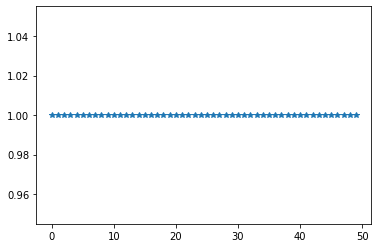

In [26]:
plt.figure()
plt.plot(p_hat,'*')

y [1 1 1 ... 1 1 1]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
y_hat [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [0.]
 [1.]]


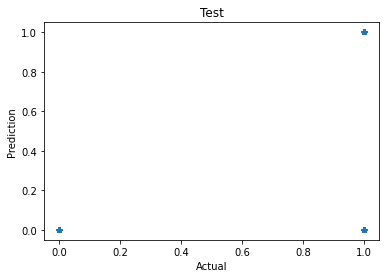

In [29]:
y_hat=model.predict(test_ds)
y=test.target
y=y.to_numpy()

print('y',y)

for i in range(len(y_hat)):
    y_hat[i]=math.floor(y_hat[i])

plt.figure()
plt.plot(y,y_hat,'*')
plt.title('Test')
plt.ylabel('Prediction')
plt.xlabel('Actual')
#plt.legend(['t', 'validation'], loc='lower right')
plt.savefig('/home/dell/Neural_net/train_coin_4/test_plot')
print(type(y))
print(type(y_hat))
print('y_hat',y_hat)

In [30]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    confusion_matrix = confusion_matrix.astype(int)

    layout = {
        "title": "Confusion Matrix", 
        "xaxis": {"title": "Predicted value"}, 
        "yaxis": {"title": "Real value"}
    }

    fig = go.Figure(data=go.Heatmap(z=confusion_matrix,
                                    x=class_names,
                                    y=class_names,
                                    hoverongaps=False),
                    layout=layout)
    fig.show()

In [31]:
class_names=['signal','noise']
plot_confusion_matrix(y,y_hat,class_names)

In [17]:
print(history)

In [32]:
os.chdir("/home/dell/Neural_net/test_coin_11")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
print(len(all_filenames))
t_hat=np.zeros(len(all_filenames))
count=0
for f in all_filenames:
    test=pandas.read_csv(f)
    test=tf.data.Dataset.from_tensor_slices(dict(test))
    pred=model.predict(test)
    t_hat[count]=max(pred)
    count=count+1
print(t_hat)

100
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [33]:
data=pandas.read_csv("/home/dell/Neural_net/verify_coin_11/verify_coin_dataset11.csv")
t=data.target

AttributeError: 'DataFrame' object has no attribute 'target'

In [1]:
acc=max(history.history['accuracy'])
acc

NameError: name 'history' is not defined